#Import libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install seqeval

from google.colab import drive
import pandas as pd
import json
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
import string
import matplotlib.pyplot as plt
from collections import Counter
import os
import sys
import logging
from pathlib import Path
import random
import gensim
import  codecs
from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import transformers
import tensorflow as tf
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import load_metric
from transformers import DataCollatorForTokenClassification

plt.style.use("ggplot")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 120 kB 65.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.7 MB/s 
     |████████████████████████████████| 212 kB 50.6 MB/s 
     |████████████████████████████████| 115 kB 50.5 MB/s 
     |████████████████████████████████| 127 kB 26.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha2

#Preprocess

##Read data and normalize it

In [ ]:
drive.mount("/content/drive")

config = {
    "parent_dir" : "/content/drive/My Drive/",
    "train_data_name" : "train.data",
    'model': "HooshvareLab/bert-fa-base-uncased",
    "length_threshold" : 128
}

normalizer = {
 "؛" : ";",
 "«" : "<<",
 "؟" : "?",
 "²" : ".",
 "،" : ",",
 "»" : ">>",
 "×" : "*",
 "ة" : "ه",
 "–" : "-",
 "ؤ" : "و",
 "½" : ".",
 "ئ" : "ی",
 "…" : ".",
}

#read raw data from path that defined in the config dictionary
with open(config["parent_dir"] + config["train_data_name"] , 'r' , encoding="utf-8") as f:
    raw_data = f.readlines()

all_pos = 0
all_words = 0
all_sentences = 0
for i in raw_data:
  if 'positive' in i:
    all_pos += 1
  all_words +=1
  if '.' in i:
    all_sentences +=1

print(all_pos,all_words,all_sentences)
print(all_pos/all_words)

#apply some correctionscorrections on the raw data and convert some characters to correct form
normalized_data = []
for line in raw_data:
    normalized_line = line
    for item in normalizer:
        normalized_line = normalized_line.replace(item , normalizer[item])
    normalized_data.append(normalized_line)
del raw_data

Mounted at /content/drive
333526 1800008 63586
0.18529139870489464


##Split data to pair of words and labels

In [ ]:
split_labeled_text = []
sentence = []
for line in normalized_data:
    if len(line)==0 or line[0]=="\n":
        if len(sentence) > 0:
            split_labeled_text.append(sentence)
            sentence = []
        continue
    splits = line.split(' ')
    sentence.append([splits[0],splits[-1].rstrip("\n")])
    
if len(sentence) > 0:
    split_labeled_text.append(sentence)
    sentence = []

##Split data to sentences

In [ ]:
sentences = []
labels = []
for data in split_labeled_text:
    sentence = []
    label = []
    for item in data:
        sentence.append(item[0])
        label.append(item[1])
    sentences.append(sentence)
    labels.append(label)

##Define labels

In [ ]:
label_2_idx = {"gen_negative" : 0 , "gen_positive" : 1}
idx_2_label = {i: l for l, i in label_2_idx.items()}

labels_to_idx = []
for data in labels:
    labels_sentence = []
    for item in data:
        labels_sentence.append(label_2_idx[item])
    labels_to_idx.append(labels_sentence)
labels = labels_to_idx

##Test and train split

In [ ]:
sentences, labels = shuffle(sentences, labels, random_state=42)

train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(sentences, labels, test_size=0.2)
valid_sentences, test_sentences, valid_labels, test_labels = train_test_split(valid_sentences, valid_labels, test_size=0.5)

#Process

##Load tokenizer

In [ ]:
MAX_LEN = 128
tokenizer = AutoTokenizer.from_pretrained(config['model'],add_prefix_space=True)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

##Create custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = self.sentences[index]
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            truncation=True,
            is_split_into_words=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        try:
            label = self.labels[index]
            label.extend([-100]*self.max_len)
            label=label[:self.max_len]
        except:
            print(index)
            print(sentence)
            raise

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': label
        } 
    
    def __len__(self):
        return self.len

training_set = CustomDataset(tokenizer, train_sentences, train_labels , MAX_LEN)
validation_set = CustomDataset(tokenizer, valid_sentences, valid_labels , MAX_LEN)
testing_set = CustomDataset(tokenizer, test_sentences, test_labels , MAX_LEN)

##Define model and metric

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(config['model'], num_labels=2)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=6e-6)
metric = load_metric("seqeval")
labels = list(label_2_idx.keys())
metric.compute(predictions=[labels], references=[labels])

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not init

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: gen_negative seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: gen_positive seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'en_negative': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'en_positive': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

##Define compute_metrics

In [ ]:
def compute_metrics(p):
    predictions , labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [idx_2_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [idx_2_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

##Train model

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

args = TrainingArguments(
config['parent_dir']+"test-ezafe/"+config['model'],
overwrite_output_dir = True,
evaluation_strategy = "epoch",
save_strategy = "epoch",
learning_rate=6e-6,
per_device_train_batch_size=32,
per_device_eval_batch_size=32,
num_train_epochs=40,
weight_decay=0.01,
load_best_model_at_end=True,
resume_from_checkpoint = True,
)

trainer = Trainer(
model,
args,
train_dataset=training_set,
eval_dataset=validation_set,
data_collator=data_collator,
tokenizer=tokenizer,
compute_metrics=compute_metrics
)

#for the first run
#trainer.train()
#for the other runs
trainer.train(resume_from_checkpoint=True)

Loading model from /content/drive/My Drive/test-ezafe/HooshvareLab/bert-fa-base-uncased/checkpoint-70120.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 56082
  Num Epochs = 40
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 70120
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 40
  Continuing training from global step 70120
  Will skip the first 40 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you w

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/My Drive/test-ezafe/HooshvareLab/bert-fa-base-uncased/checkpoint-66614 (score: 0.013275288045406342).


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=70120, training_loss=0.0, metrics={'train_runtime': 9.7258, 'train_samples_per_second': 230652.1, 'train_steps_per_second': 7209.677, 'total_flos': 1.4654044711268352e+17, 'train_loss': 0.0, 'epoch': 40.0})

##Evaluation loss

1 0.08507014065980911
2 0.06265398859977722
3 0.05777749791741371
4 0.0575285330414772
5 0.03925048187375069
6 0.04328702390193939
7 0.03961540386080742
8 0.04218485206365585
9 0.025833435356616974
10 0.026311924681067467
11 0.027971014380455017
12 0.0292835533618927
13 0.029005752876400948
14 0.027954859659075737
15 0.027595801278948784
16 0.022554222494363785
17 0.020534710958600044
18 0.02145228534936905
19 0.021027376875281334
20 0.019902197644114494
21 0.019518697634339333
22 0.019069859758019447
23 0.019841110333800316
24 0.01845197193324566
25 0.019191721454262733
26 0.019070303067564964
27 0.018920889124274254
28 0.019923215731978416
29 0.0165172778069973
30 0.01666051149368286
31 0.013862254098057747
32 0.014742345549166203
33 0.014279527589678764
34 0.014002935960888863
35 0.014056339859962463
36 0.014000196941196918
37 0.01344373356550932
38 0.013275288045406342
39 0.013379156589508057
40 0.013373271562159061


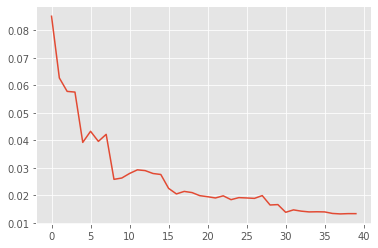

In [ ]:
arr = []
for obj in trainer.state.log_history:
    if obj['epoch']*100 % 100 == 0:
      if 'eval_loss' in obj.keys(): 
        arr.append(obj['eval_loss'])
        print(int(obj['epoch']),obj['eval_loss'])
plt.plot(arr)

#Save model and predict on testing set

###Virgool separating

In [ ]:
virg_tokenizer = BertTokenizer.from_pretrained(config['parent_dir'] + 'virgool_res/')
virg_model = AutoModelForTokenClassification.from_pretrained(config['parent_dir'] + 'virgool_res/', num_labels=2)
virg_trainer = Trainer(virg_model,tokenizer=virg_tokenizer)
virg_result = virg_trainer.predict(testing_set)
virg_predict_lables = np.argmax(virg_result.predictions,-1)

###Prediction

In [ ]:
result = trainer.predict(testing_set)
predict_lables = np.argmax(result.predictions,-1)
true_lables = result.label_ids

***** Running Prediction *****
  Num examples = 7011
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/data/data_collator.py:318: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_length = torch.tensor(batch["input_ids"]).shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/data/data_col

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: gen_negative seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: gen_positive seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


### Calculate scores

In [ ]:
pl = []
tl = []
vpl = []

for i in range(len(predict_lables)):
    sentence_len = len(test_sentences[i])
    pred_label = predict_lables[i][:sentence_len]
    true_label = true_lables[i][:sentence_len]
    pl.extend(pred_label.tolist())
    tl.extend(true_label.tolist())
    
    # Virgool separating
    virg_pred_label = virg_predict_lables[i][:sentence_len]
    vpl.extend(virg_pred_label.tolist())
    if 1 in vpl:
      for j in range(len(test_sentences[i])):
        if vpl[j] == 1:
          pl[j] = 0

from sklearn.metrics import classification_report, 	f1_score, accuracy_score

print("Accuracy : " , accuracy_score(tl, pl))
print("F1-Score : " , f1_score(tl, pl))

print("\n------------------Classification Report------------------\n")
print(classification_report(tl, pl, target_names=['Negative' , 'Positive'],digits=4))

Accuracy :  0.996118155499676
F1-Score :  0.9898027702734358

------------------Classification Report------------------

              precision    recall  f1-score   support

    Negative     0.9979    0.9973    0.9976    136236
    Positive     0.9887    0.9909    0.9898     31983

    accuracy                         0.9961    168219
   macro avg     0.9933    0.9941    0.9937    168219
weighted avg     0.9961    0.9961    0.9961    168219



In [ ]:
trainer.save_model(config['parent_dir']+'final model')

Saving model checkpoint to /content/drive/My Drive/final model
Configuration saved in /content/drive/My Drive/final model/config.json
Model weights saved in /content/drive/My Drive/final model/pytorch_model.bin
tokenizer config file saved in /content/drive/My Drive/final model/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/final model/special_tokens_map.json


#See an example of its prediction

In [ ]:
i = 41
for a , b , c in zip(test_sentences[i] , predict_lables[i] , true_lables[i]):
  print(a,b,c)

به 0 0
احمدیان 0 0
سرپرست 1 1
اداره 1 1
امور 1 1
عشایری 1 1
شهرستان 1 1
فریدون‌شهر 0 0
گفت 0 0
: 0 0
عشایر 0 0
در 0 0
مناطق 1 1
فریدون‌شهر 0 0
, 0 0
داران 0 0
و 0 0
چنارود 1 1
چادگان 0 0
مستقر 0 0
می‌شوند 0 0
. 0 0
